In [1]:
# first import data 
#sshfs ascott47@jhu.edu@gateway2.marcc.jhu.edu:/scratch/groups/bzaitch1/badr/ mountpoint/
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import matplotlib.cm as cm
import scipy.spatial
import os 
import string
import scipy.stats

home_dir = os.getenv("HOME")

#source activate python2
from netCDF4 import Dataset
from wrf import getvar
import wrf
from wrf import ALL_TIMES

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [102]:
filepath = '../cityheat/Bmore/2016/'
meta = pd.DataFrame(pd.read_csv(filepath + 'data/CleanedMeta2016.csv', sep = ','))
meta = meta.set_index('sensornumber', drop = False)
meta = meta.set_index(meta.index.astype('float64'), drop = False)
#mean_temp = pd.read_csv('meantemp.csv', header=-1).rename(columns = {0: 'SensorNumber', 1:'MeanTemp'}).set_index('SensorNumber')
tempDF = pd.read_csv(filepath + 'data/CleanedTemp2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')#.first()
tempDF.columns = tempDF.columns.astype('int')
# remove data before the thermometer was installed
for ind in tempDF.columns : 
    start_hour = pd.to_datetime(meta.loc[ind,'time'][0:13] + ':00:00 UTC ' + meta.loc[ind,'time'][-4:])
    tempDF.loc[:start_hour,ind] = np.nan
    
start_date = '2016-07-01'
end_date = '2016-08-30'
tempDF = tempDF[start_date:end_date][meta['location:Longitude'].dropna().index].drop(41,axis=1)
meta =meta.loc[tempDF.columns]
# remember to subtract bias

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()


In [115]:
exp = 'UCM+SST'
dom = 'd03'
fpath = home_dir + '/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
analysis_points = meta[['location:Longitude', 'location:Latitude']].dropna()
nchunks = 20
df = pd.DataFrame( columns=analysis_points.index, index = [file[-19:] for file in files])
n = 0
for i in range(nchunks):
    dataset_list = []
    for file in files[n,n+len(files)/nchunks]: 
        dataset_list.append(Dataset(file))

    t2 = getvar(dataset_list, varname = "T2", 
              timeidx = wrf.ALL_TIMES, 
              method = 'cat'
              )
    # convert to degrees C
    t2 = t2 - 273.15
    pts = wrf.ll_to_xy(dataset_list[-1],analysis_points['location:Latitude'], analysis_points['location:Longitude'])
    #data = t2.isel(west_east = pts.values[0], south_north = pts.values[1])
    df.loc[files[n][-19:], files[n+len(files)/nchunks][-19:]] = t2.isel(west_east = pts.values[0], south_north = pts.values[1])
    n= n+len(files)/nchunks
    
df.to_csv('%s_%s_allpoints.csv'%(exp,dom))
lc = getvar(dataset_list[-1], "LU_INDEX")
lc.to_csv('%s_%s_landcover.csv'%(exp,dom))

In [ ]:
# do in python
import pandas as pd
from netCDF4 import Dataset
from wrf import getvar
import wrf
from wrf import ALL_TIMES
import os
import glob
import numpy as np

filepath = '../cityheat/Bmore/2016/'
meta = pd.DataFrame(pd.read_csv(filepath + 'data/CleanedMeta2016.csv', sep = ','))
meta = meta.set_index('sensornumber', drop = False)
meta = meta.set_index(meta.index.astype('float64'), drop = False)
#mean_temp = pd.read_csv('meantemp.csv', header=-1).rename(columns = {0: 'SensorNumber', 1:'MeanTemp'}).set_index('SensorNumber')
tempDF = pd.read_csv(filepath + 'data/CleanedTemp2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')#.first()
tempDF.columns = tempDF.columns.astype('int')
# remove data before the thermometer was installed
for ind in tempDF.columns : 
    start_hour = pd.to_datetime(meta.loc[ind,'time'][0:13] + ':00:00 UTC ' + meta.loc[ind,'time'][-4:])
    tempDF.loc[:start_hour,ind] = np.nan
    
start_date = '2016-07-01'
end_date = '2016-08-30'
tempDF = tempDF[start_date:end_date][meta['location:Longitude'].dropna().index].drop(41,axis=1)
meta =meta.loc[tempDF.columns]

home_dir = os.getenv("HOME")
exp = 'UCM+SST'
dom = 'd03'
fpath = home_dir + '/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
analysis_points = meta[['location:Longitude', 'location:Latitude']].dropna()
nchunks = 20
df = pd.DataFrame( columns=analysis_points.index, index = [file[-19:] for file in files])
n = 0
for i in range(nchunks):
    dataset_list = []
    for file in files[n:n+(len(files)/nchunks)]: 
        dataset_list.append(Dataset(file))

    t2 = getvar(dataset_list, varname = "T2", 
              timeidx = wrf.ALL_TIMES, 
              method = 'cat'
              )
    # convert to degrees C
    t2 = t2 - 273.15
    pts = wrf.ll_to_xy(dataset_list[-1],analysis_points['location:Latitude'], analysis_points['location:Longitude'])
    #data = t2.isel(west_east = pts.values[0], south_north = pts.values[1])
    df.loc[files[n][-19:]:files[n+len(files)/nchunks-1][-19:],:] = np.diagonal(t2.isel(west_east = pts.values[0], south_north = pts.values[1]), axis1=1,axis2=2)
    n= n+len(files)/nchunks
    for ds in dataset_list: 
        ds.close()
    t2.close()
    df.to_csv('data/%s_%s_allpoints.csv'%(exp,dom))

df.to_csv('data/%s_%s_allpoints.csv'%(exp,dom))
lc = getvar(dataset_list[-1], "LU_INDEX")
lc.to_csv('data/%s_%s_landcover.csv'%(exp,dom))

UCM+SST_d03_allpoints.csv


In [150]:
np.diagonal(t2.isel(west_east = pts.values[0], south_north = pts.values[1]), axis1=1,axis2=2)

(24, 85)

In [58]:
lcc_english = {
    #! 40 CLASS MODIS (Outside US, cats 1-20)/NLCD (US only, cats 21-40) LU characterization
    # downloaded from https://github.com/yyr/wrf/blob/master/phys/module_sf_pxlsm_data.F March 8 2018
    1: 'Evergreen Needleleaf Forest',
    2:  'Evergreen Broadleaf Forest',
    3:  'Deciduous Needleleaf Forest',
    4:   'Deciduous Broadleaf Forest',
    5: 'Mixed Forest',
    6:  'Closed Shrublands', 
    7:'Open Shrublands', 
    8: 'Woody Savanna', 
    9:'Savanna', 
    10: 'Grasslands', 
    11: 'Perminent Wetlands', 
    12: 'Croplands',
    13: 'Urban andBuilt-up', 
    14: 'Cropland/Natural Vegetation Mosaic', 
    15: 'Snow and Ice', 
    16: 'Barren or Sparsely Vegetated', 
    17:  'IGBP water', 
    18: 'unclassified', 
    19: 'fill value (normally ocean water)', 
    20: 'unclassified', 
    21: 'Open water', 
    22: 'Perennial Ice/snow', 
    23: 'Developed, Open space', 
    24:'Developed, Low Intensity', 
    25: 'Developed, Medium Intensity', 
    26: 'Developed, High Intensity', 
    27: 'Barren land', 
    28: 'Deciduous Forest', 
    29: 'Evergreen Forest', 
    30: 'Mixed Forest',
    31: 'Dwarf Scrub', 
    32:  'Shrub/Scrub', 
    33: 'Grassland/Herbaceous', 
    34: 'Sedge/Herbaceous',
    35: 'Lichens', 
    36: 'Moss', 
    37: 'Pasture/Hay',
    38: 'Cultivated Crops',
    39: 'Woody Wetland',
    40: 'Emergent Herbaceous Wetland',
}

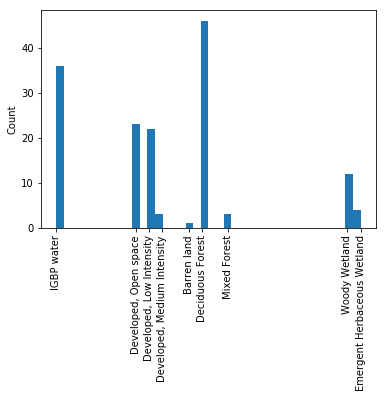

In [71]:
patches = plt.hist(np.diag(lc), bins = 40)
markers = plt.xticks(np.unique(np.diag(lc)),
                     [lcc_english[int(x)]for x in np.unique(np.diag(lc))], rotation='vertical')
plt.ylabel('Count')

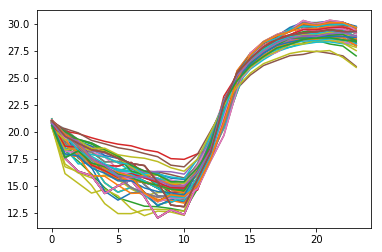

In [43]:
for i in range(len(analysis_points)):
    plt.plot(data[:,i,i])

In which run has largest UHI, we saw that the UCM 6am run has largest UHI

# Compute error statistics

RMSE, correlation, bias, hit rate, index of agreement, and coefficient of determination

In [271]:
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d_%H:%M:%S') -pd.Timedelta('4h')
model = pd.read_csv('data/UCM+SST_d03_allpoints.csv',parse_dates=['Unnamed: 0'],date_parser=date_parser).set_index('Unnamed: 0')[tempDF.index[0]:tempDF.index[-1]]

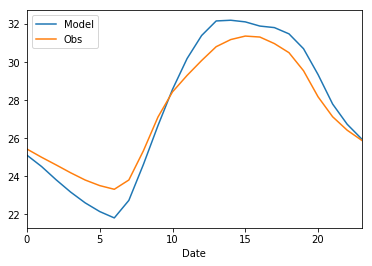

In [282]:
model.groupby(model.index.hour).mean().mean(axis=1).plot()
tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).plot()
plt.legend(['Model', 'Obs'],loc=2)

In [242]:
# rmse
from sklearn.metrics import mean_squared_error
# correlation 
# coefficient of determination: r**2
# hit rate 
def pbias(obs, sim): 
    return 100*(sim-obs).sum()/(obs).sum()
# index of agreement
def mioa(obs,sim,  j =2): 
    return 1 - (((obs-sim)**j).sum())/( (abs(sim-obs.mean())+abs(obs-obs.mean()))**j).sum() 

In [283]:
# make sure it's for the same dates
# make sure that tempDF and meta are indexed in the same order
stats_df = pd.DataFrame(index = ['rmse', 'correlation', 'p-value', 'pbias' ,'mioa'])#, columns=['all data', 6, 16])

# all data 
obs = tempDF.mean().values
sim = model.mean().values
stats_df.loc['rmse', 'all data'] = mean_squared_error(obs,sim)
stats_df.loc[['correlation', 'p-value'], 'all data'] = scipy.stats.pearsonr(obs,sim)
stats_df.loc['r_squared', 'all data'] = scipy.stats.pearsonr(obs,sim)[0]**2
stats_df.loc['pbias', 'all data'] = pbias(obs,sim)
stats_df.loc['mioa', 'all data'] = mioa(obs,sim)

# hourly data 
for hr in [6,16]: 
    obs = tempDF[tempDF.index.hour ==hr].mean().values
    sim = model[model.index.hour==hr].mean().values
    stats_df.loc['rmse', hr] = mean_squared_error(obs,sim)
    stats_df.loc[['correlation', 'p-value'], hr] = scipy.stats.pearsonr(obs,sim)
    stats_df.loc['r_squared', hr] = scipy.stats.pearsonr(obs,sim)[0]**2
    stats_df.loc['pbias', hr] = pbias(obs,sim)
    stats_df.loc['mioa', hr] = pbias(obs,sim)

stats_df
# # pretty print latex table : 
# vars = [rmse,correlation[0]]
# labels = ['RMSE', 'r']
# for var, label in zip(vars,labels): 
#     print('%s & %2.2f \\\\'%(label,var))

,all data,6,16
rmse,8.181977e-01,3.313241e+00,3.653377
correlation,6.931034e-01,5.430354e-01,0.480766
p-value,1.974532e-13,7.897980e-08,0.000003
pbias,2.671038e-01,-6.451190e+00,1.841714
mioa,7.217172e-01,-6.451190e+00,1.841714
r_squared,4.803924e-01,2.948874e-01,0.231136


In [284]:
print(stats_df.to_latex(float_format=lambda x:'%2.2f'%x))#.replace('\n', ' '))

\begin{tabular}{lrrr}
\toprule
{} &  all data &     6 &   16 \\
\midrule
rmse        &      0.82 &  3.31 & 3.65 \\
correlation &      0.69 &  0.54 & 0.48 \\
p-value     &      0.00 &  0.00 & 0.00 \\
pbias       &      0.27 & -6.45 & 1.84 \\
mioa        &      0.72 & -6.45 & 1.84 \\
r\_squared   &      0.48 &  0.29 & 0.23 \\
\bottomrule
\end{tabular}



In [ ]:
# ['SciCenter', 'Urban Forest', 'Urban Park', 'Rural', 'Inner City']
selected_pts = [] # probably: developed low intensity, developed medium intensity 

# Diurnal cycle 

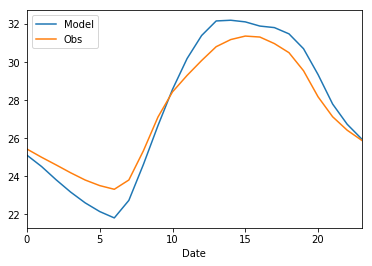

In [285]:
model.groupby(model.index.hour).mean().mean(axis=1).plot()
tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).plot()
plt.legend(['Model', 'Obs'],loc=2)

# UHI intensity as a function of distance from the city center
# Variability within city


# Variability by landcover type


# Change during warmer periods
